In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('query_result_2021-02-16T16_50_56.834609Z.csv')

Смотрим, что получилось

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   departure_airport    127 non-null    object 
 2   arrival_airport      127 non-null    object 
 3   scheduled_departure  127 non-null    object 
 4   scheduled_arrival    127 non-null    object 
 5   model                127 non-null    object 
 6   flight_incom         118 non-null    float64
 7   occupancy            127 non-null    int64  
 8   capacity             127 non-null    int64  
 9   flight_time          127 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 10.0+ KB


In [4]:
# Справочник о характеристиках самолета
aircraft_info = {
    'Boeing 737-300': {'fuel': 2400,
                       'weight': 62.82
                      },
    'Sukhoi Superjet-100': {'fuel': 1700,     # расход топлива кг в 60 мин
                            'weight': 45.88   # МВМ в тоннах
                           }}

In [5]:
# Здесь расписываем сколько топлива в час "ест" каждая модель самолета
jet_fuel =[]
for model in df.model:
    if model =='Sukhoi Superjet-100':
        jet_fuel.append(1700)
    else: 
        jet_fuel.append(2400)
df['jet_fuel'] = jet_fuel


In [6]:
# А также максимальную взлетную массу в тоннах
mwm =[]
for model in df.model:
    if model =='Sukhoi Superjet-100':
        mwm.append(45.88)
    else: 
        mwm.append(62.82)
df['aircraft_weight'] = mwm

In [7]:
# Справочник о сборах аэропорта
airport_info = {
    'EGO': {'landing': 500,      # сбор за взлет-посадку руб/тонну
            'parking': 0.05,     # сбор за стоянку коэф.от 'landing'
            'seсurity': 300      # сбор за авиационную безопасность
           }, 
    'SVO': {'landing': 178.3,
            'parking': 0.05,
            'seсurity': 54.6      
           }
               }

In [8]:
df['landing_price'] = df[df['arrival_airport'] != 'NOZ']['arrival_airport'].apply(lambda x: airport_info[x]['landing'])
df['parking_price'] = df[df['arrival_airport'] != 'NOZ']['arrival_airport'].apply(lambda x: airport_info[x]['parking'])
# df['securiy_price'] = df[df['arrival_airport'] != 'NOZ']['arrival_airport'].apply(lambda x: airport_info[x]['security']) почему-то тут выдает ошибку

In [9]:
security=[]
for i in df.arrival_airport:
    if i == 'SVO':
        security.append(54.6)
    elif i == 'EGO':
        security.append(300)
    else:
        security.append(0)
df['security_price'] = security

Отдельно можно посчитать сборы аэропорта за наземное обслуживание, сгруппировав всю сумму в одну переменную

In [10]:
df['ground_handling'] = df.landing_price * df.aircraft_weight + df.landing_price * df.aircraft_weight * df.parking_price + df.security_price * df.aircraft_weight

Расходы на топливо

In [11]:
df['fuel_price'] = 40    #  руб за 1 кг


In [12]:
df['fuel_cost'] = df['flight_time'] * df['jet_fuel'] / 60 * df['fuel_price']

Теперь можно посчитать прибыльность 

In [13]:
df['flight_summary'] = df['flight_incom'] - df['fuel_cost'] - df['ground_handling']

In [14]:
# странные пропорции, возможно я ошибся с ценой на топливо
df['flight_summary']/df['fuel_cost']

0      11.726159
1       8.542557
2       9.492041
3       8.710057
4            NaN
         ...    
122    11.837335
123     8.695057
124          NaN
125     8.480865
126     9.305057
Length: 127, dtype: float64

Итак, у нас 2 ежедневных рейса в Москву и Белгород. Посмотрим на их прибыльность

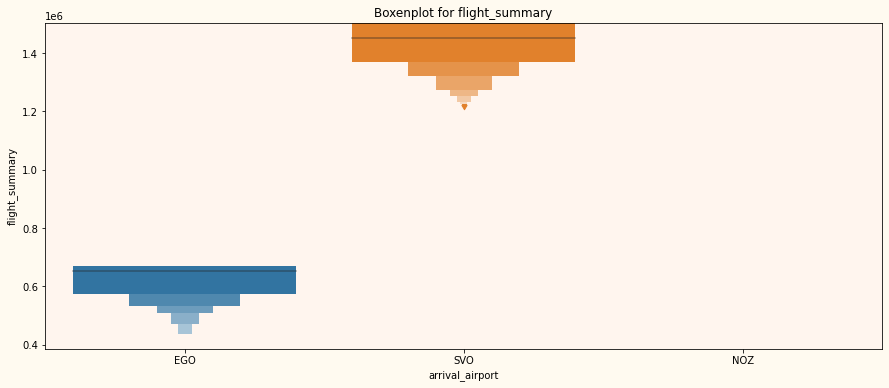

In [15]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
sns.boxenplot(x='arrival_airport', y='flight_summary', 
                data=df,
               ax=ax)
          
ax.set_title('Boxenplot for flight_summary' )
plt.show()

In [16]:
df['dep_time'] = pd.to_datetime(df['scheduled_departure']).dt.tz_localize(None)
df['arr_time'] = pd.to_datetime(df['scheduled_arrival']).dt.tz_localize(None)
df['day_of_week'] = pd.to_datetime(df['dep_time']).dt.dayofweek

In [17]:
df['date'] = df['dep_time'].map(lambda x: x.strftime('%Y-%m-%d'))
df.date

0      2017-01-01
1      2017-01-01
2      2017-01-02
3      2017-01-02
4      2017-01-03
          ...    
122    2017-02-27
123    2017-02-27
124    2017-02-28
125    2017-02-28
126    2017-02-28
Name: date, Length: 127, dtype: object

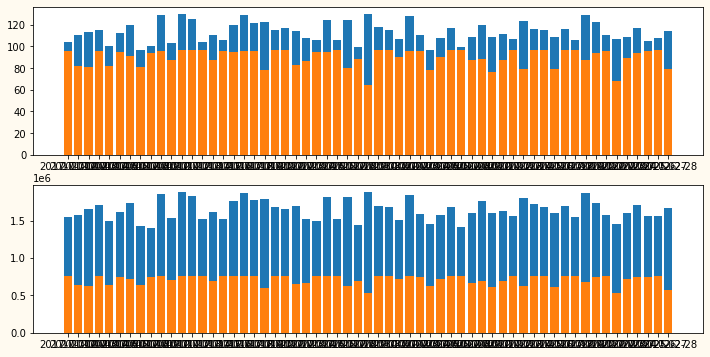

In [18]:
x = df[df['arrival_airport'] == 'EGO']['date']
y1 = df[df['arrival_airport'] == 'SVO']['occupancy']
y2 = df[df['arrival_airport'] == 'EGO']['occupancy']
y3 = df[df['arrival_airport'] == 'SVO']['flight_incom']
y4 = df[df['arrival_airport'] == 'EGO']['flight_incom']
fig = plt.figure()

ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 1, 2)

ax_1.bar(x, y1)
ax_1.bar(x, y2)

ax_2.bar(x, y3)
ax_2.bar(x, y4)


fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
